## **LIBRARIES IMPORTED AND SETUP**

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random
import seaborn as sns
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 

# Setup device (gpu or cpu)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla T4


## **NEW DATASET LOADER**

In [2]:
def get_transforms(size, normalize, split):
    """
    Get data transforms for CIFAR100

    Args:
        size: Image size ('32' or '224')
        normalize: Normalization type ('standard' or 'imagenet')
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
    Returns:
        torchvision.transforms.Compose object
    """
    if normalize == "imagenet":
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == "standard":
        mean = [0.5071, 0.4865, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
    transform_list = []
    # Add data augmentation for training
    if split == "train":
        if size == "224":
            train_transform = transform_list.extend(
                [
                    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
                ]
            )
        elif size == "32":
            train_transform = transform_list.extend(
                [
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                ]
            )
    elif split == "test":
        if size == "224":
            test_transform = transform_list.extend(
                [
                    transforms.Resize((224, 224)),
                ]
            )

    # Add basic transforms
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean, std)])

    return transforms.Compose(transform_list)

In [3]:
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
    torch.manual_seed(SEED + worker_id)

In [4]:
def CIFAR100DataLoader_v2(
    split,
    batch_size=8,
    num_workers=2,
    shuffle=True,
    size="32",
    normalize="standard",
    seed=42,
):
    """
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')

    Output:
        DataLoader Object
    """

    # Get appropriate transforms
    transforms = get_transforms(size, normalize, split)
    if split == "train":
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=True, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )
    else:
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=False, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )

## **VIT MODEL SETUP**

In [5]:
# Attention layer
class Attention(nn.Module):
    """
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :-
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    """

    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) |
        # reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) |
        # Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)

        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Feed Forward layer
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    """
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    """

    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block
class TransformerBlock(nn.Module):
    """
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-

    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    """

    def __init__(
        self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1
    ):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res

        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block with multi layer
class Transformer(nn.Module):
    """
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    """

    def __init__(
        self,
        embed_dim,
        layers,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim, heads, activation, forward_expansion, dropout
                )
                for i in range(layers)
            ]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# MLP Head
class ClassificationHead(nn.Module):
    """
    Classification Head attached to the first sequence token which is used as the arbitrary
    classification token and used to optimize the transformer model by applying Cross-Entropy
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    """

    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes)
        return out


class VisionTransformer(nn.Module):
    """
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|

    Args:
        patch_size: Length of square patch size
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)

    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    """

    def __init__(
        self,
        patch_size,
        max_len,
        embed_dim,
        classes,
        layers,
        channels=3,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        self.name = "VisionTransformer"
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(
            embed_dim, layers, heads, activation, forward_expansion, dropout
        )
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        # Split image into small patch
        out = (
            inp.unfold(2, self.patch_size, self.patch_size)
            .unfold(3, self.patch_size, self.patch_size)
            .contiguous()
        )
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) |
        # seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()

        # Flatten patch into 1 dimension
        out = out.reshape(batch_size, seq_len, -1)
        # Mapping from patch 1 dimension to hidden embedding dimension
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        # Add class token to head of embedding vector
        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[: seq_len + 1]
        position_embed = position_embed.unsqueeze(0).expand(
            batch_size, seq_len + 1, self.embed_dim
        )
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim)
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)

        return class_out, out

## **TRAINING, EVALUATION AND TESTING FUNCTION**

In [6]:
# Training model
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    """
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    """
    running_loss = 0.0
    running_accuracy = 0.0
    index = 0
    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)
        if model.name == "VisionTransformer":
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == "ResNet":
            output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy


# Validation model
def evaluation(model, dataloader, criterion, resnet_features=None):
    """
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    """
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy


def test(model, dataloader, resnet_features=None):
    """
    Function used to test the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        all_preds: All model predict label (Int)
        all_labels: All dataset label (Int)
    """
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, label in tqdm(dataloader):
            data = data.to(device)
            target = label.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)

            pred = output.argmax(dim=1)
            all_preds.extend(pred)
            all_labels.extend(label)

    return all_preds, all_labels

## **INITIALIZE VARIABLE**

In [7]:
max_len = 100  # All sequences must be less than 1000 including class token
classes = 100
image_sz = 32
channels = 3

lr = 0.001
epochs = 100

patch_size = 16
batch_size = 32
num_workers = 2
shuffle = True

embed_dim = 768

layers = 12
heads = 12

resnet_features_channels = 64

In [8]:
# Init model
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads,
).to(device)

resnet_features = None

## **TRAINING AND TEST**

In [9]:
# Init data loader
train_dataloader = CIFAR100DataLoader_v2(
    split="train",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=shuffle,
    size="32",
    normalize="standard",
)
test_dataloader = CIFAR100DataLoader_v2(
    split="test",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    size="32",
    normalize="standard",
)

100%|██████████| 169001437/169001437 [00:02<00:00, 74540750.48it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
# Initialize first time training
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs
)

train_accs = []
test_accs = []
last_epoch = 0

In [11]:
# Record the start time
start_time = time.time()
# Running
for epoch in range(epochs - last_epoch):
    epoch += last_epoch
    running_loss, running_accuracy = train(
        model, train_dataloader, criterion, optimizer, scheduler, resnet_features
    )
    print(
        f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n"
    )
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(
        model, test_dataloader, criterion, resnet_features
    )
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch + 1) % 10 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model": model,
                "optimizer": optimizer,
                "scheduler": scheduler,
                "train_acc": train_accs,
                "test_acc": test_accs,
            },
            model.name + "_patch16-768d-12h-12l_CIFAR100_checkpoint_" + str(epoch) + ".pt",
        )

torch.save(
    {
        "epoch": epoch,
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "train_acc": train_accs,
        "test_acc": test_accs,
    },
    model.name + "_patch16-768d-12h-12l_CIFAR100.pt",
)

# Record the end time
end_time = time.time()
# Calculate the time difference
time_difference = end_time - start_time

print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
# print(f"Time Taken: {time_difference} seconds")

100%|██████████| 1563/1563 [01:04<00:00, 24.22it/s]


Epoch : 1 - acc: 0.0689 - loss : 4.1799



100%|██████████| 313/313 [00:03<00:00, 86.68it/s]


test acc: 0.1060 - test loss : 3.8886



100%|██████████| 1563/1563 [01:01<00:00, 25.30it/s]


Epoch : 2 - acc: 0.1118 - loss : 3.8488



100%|██████████| 313/313 [00:03<00:00, 85.89it/s]


test acc: 0.1401 - test loss : 3.7202



100%|██████████| 1563/1563 [01:02<00:00, 24.93it/s]


Epoch : 3 - acc: 0.1342 - loss : 3.7148



100%|██████████| 313/313 [00:03<00:00, 82.71it/s]


test acc: 0.1401 - test loss : 3.6617



100%|██████████| 1563/1563 [01:02<00:00, 24.92it/s]


Epoch : 4 - acc: 0.1491 - loss : 3.6107



100%|██████████| 313/313 [00:03<00:00, 83.98it/s]


test acc: 0.1674 - test loss : 3.5138



100%|██████████| 1563/1563 [01:02<00:00, 25.01it/s]


Epoch : 5 - acc: 0.1639 - loss : 3.5220



100%|██████████| 313/313 [00:03<00:00, 91.31it/s] 


test acc: 0.1761 - test loss : 3.4646



100%|██████████| 1563/1563 [01:02<00:00, 24.85it/s]


Epoch : 6 - acc: 0.1778 - loss : 3.4391



100%|██████████| 313/313 [00:03<00:00, 91.62it/s] 


test acc: 0.1786 - test loss : 3.4100



100%|██████████| 1563/1563 [01:02<00:00, 24.86it/s]


Epoch : 7 - acc: 0.1908 - loss : 3.3663



100%|██████████| 313/313 [00:03<00:00, 80.04it/s]


test acc: 0.2023 - test loss : 3.3425



100%|██████████| 1563/1563 [01:02<00:00, 24.82it/s]


Epoch : 8 - acc: 0.1992 - loss : 3.3112



100%|██████████| 313/313 [00:03<00:00, 82.48it/s]


test acc: 0.2095 - test loss : 3.2676



100%|██████████| 1563/1563 [01:02<00:00, 25.07it/s]


Epoch : 9 - acc: 0.2098 - loss : 3.2597



100%|██████████| 313/313 [00:03<00:00, 92.17it/s]


test acc: 0.2155 - test loss : 3.2432



100%|██████████| 1563/1563 [01:02<00:00, 24.93it/s]


Epoch : 10 - acc: 0.2174 - loss : 3.2186



100%|██████████| 313/313 [00:03<00:00, 88.87it/s] 


test acc: 0.2200 - test loss : 3.2058



100%|██████████| 1563/1563 [01:02<00:00, 24.82it/s]


Epoch : 11 - acc: 0.2240 - loss : 3.1758



100%|██████████| 313/313 [00:03<00:00, 94.34it/s]


test acc: 0.2288 - test loss : 3.1916



100%|██████████| 1563/1563 [01:03<00:00, 24.74it/s]


Epoch : 12 - acc: 0.2326 - loss : 3.1287



100%|██████████| 313/313 [00:03<00:00, 79.72it/s]


test acc: 0.2400 - test loss : 3.1503



100%|██████████| 1563/1563 [01:02<00:00, 25.10it/s]


Epoch : 13 - acc: 0.2379 - loss : 3.0941



100%|██████████| 313/313 [00:03<00:00, 85.73it/s]


test acc: 0.2391 - test loss : 3.1402



100%|██████████| 1563/1563 [01:03<00:00, 24.81it/s]


Epoch : 14 - acc: 0.2457 - loss : 3.0565



100%|██████████| 313/313 [00:03<00:00, 86.46it/s]


test acc: 0.2461 - test loss : 3.1131



100%|██████████| 1563/1563 [01:02<00:00, 24.90it/s]


Epoch : 15 - acc: 0.2532 - loss : 3.0191



100%|██████████| 313/313 [00:03<00:00, 90.80it/s]


test acc: 0.2530 - test loss : 3.0950



100%|██████████| 1563/1563 [01:02<00:00, 25.05it/s]


Epoch : 16 - acc: 0.2571 - loss : 2.9773



100%|██████████| 313/313 [00:03<00:00, 83.94it/s]


test acc: 0.2552 - test loss : 3.0517



100%|██████████| 1563/1563 [01:02<00:00, 24.82it/s]


Epoch : 17 - acc: 0.2633 - loss : 2.9558



100%|██████████| 313/313 [00:03<00:00, 88.90it/s]


test acc: 0.2607 - test loss : 3.0679



100%|██████████| 1563/1563 [01:02<00:00, 24.94it/s]


Epoch : 18 - acc: 0.2696 - loss : 2.9234



100%|██████████| 313/313 [00:03<00:00, 85.13it/s]


test acc: 0.2626 - test loss : 3.0366



100%|██████████| 1563/1563 [01:02<00:00, 25.05it/s]


Epoch : 19 - acc: 0.2742 - loss : 2.8921



100%|██████████| 313/313 [00:03<00:00, 91.80it/s]


test acc: 0.2640 - test loss : 3.0335



100%|██████████| 1563/1563 [01:02<00:00, 25.19it/s]


Epoch : 20 - acc: 0.2786 - loss : 2.8727



100%|██████████| 313/313 [00:03<00:00, 91.32it/s]


test acc: 0.2718 - test loss : 3.0194



100%|██████████| 1563/1563 [01:02<00:00, 24.89it/s]


Epoch : 21 - acc: 0.2840 - loss : 2.8430



100%|██████████| 313/313 [00:03<00:00, 93.29it/s]


test acc: 0.2659 - test loss : 2.9974



100%|██████████| 1563/1563 [01:02<00:00, 25.16it/s]


Epoch : 22 - acc: 0.2868 - loss : 2.8163



100%|██████████| 313/313 [00:03<00:00, 84.33it/s]


test acc: 0.2717 - test loss : 2.9906



100%|██████████| 1563/1563 [01:01<00:00, 25.34it/s]


Epoch : 23 - acc: 0.2923 - loss : 2.7931



100%|██████████| 313/313 [00:04<00:00, 77.95it/s]


test acc: 0.2743 - test loss : 2.9783



100%|██████████| 1563/1563 [01:02<00:00, 25.04it/s]


Epoch : 24 - acc: 0.2943 - loss : 2.7676



100%|██████████| 313/313 [00:03<00:00, 87.70it/s]


test acc: 0.2773 - test loss : 2.9749



100%|██████████| 1563/1563 [01:01<00:00, 25.21it/s]


Epoch : 25 - acc: 0.3036 - loss : 2.7454



100%|██████████| 313/313 [00:03<00:00, 86.06it/s]


test acc: 0.2779 - test loss : 2.9927



100%|██████████| 1563/1563 [01:02<00:00, 24.91it/s]


Epoch : 26 - acc: 0.3073 - loss : 2.7193



100%|██████████| 313/313 [00:03<00:00, 95.50it/s]


test acc: 0.2765 - test loss : 2.9788



100%|██████████| 1563/1563 [01:01<00:00, 25.27it/s]


Epoch : 27 - acc: 0.3143 - loss : 2.6919



100%|██████████| 313/313 [00:03<00:00, 91.96it/s]


test acc: 0.2766 - test loss : 2.9681



100%|██████████| 1563/1563 [01:01<00:00, 25.23it/s]


Epoch : 28 - acc: 0.3174 - loss : 2.6618



100%|██████████| 313/313 [00:03<00:00, 89.58it/s] 


test acc: 0.2891 - test loss : 2.9244



100%|██████████| 1563/1563 [01:02<00:00, 25.00it/s]


Epoch : 29 - acc: 0.3232 - loss : 2.6345



100%|██████████| 313/313 [00:03<00:00, 93.78it/s] 


test acc: 0.2882 - test loss : 2.9558



100%|██████████| 1563/1563 [01:02<00:00, 25.04it/s]


Epoch : 30 - acc: 0.3266 - loss : 2.6175



100%|██████████| 313/313 [00:03<00:00, 91.26it/s] 


test acc: 0.2948 - test loss : 2.9255



100%|██████████| 1563/1563 [01:02<00:00, 25.19it/s]


Epoch : 31 - acc: 0.3314 - loss : 2.5903



100%|██████████| 313/313 [00:03<00:00, 82.80it/s]


test acc: 0.2903 - test loss : 2.9205



100%|██████████| 1563/1563 [01:02<00:00, 25.03it/s]


Epoch : 32 - acc: 0.3385 - loss : 2.5679



100%|██████████| 313/313 [00:03<00:00, 87.25it/s]


test acc: 0.2955 - test loss : 2.9256



100%|██████████| 1563/1563 [01:02<00:00, 25.16it/s]


Epoch : 33 - acc: 0.3438 - loss : 2.5453



100%|██████████| 313/313 [00:03<00:00, 91.47it/s]


test acc: 0.2951 - test loss : 2.9094



100%|██████████| 1563/1563 [01:02<00:00, 24.92it/s]


Epoch : 34 - acc: 0.3472 - loss : 2.5161



100%|██████████| 313/313 [00:03<00:00, 83.54it/s]


test acc: 0.2991 - test loss : 2.9140



100%|██████████| 1563/1563 [01:02<00:00, 24.88it/s]


Epoch : 35 - acc: 0.3481 - loss : 2.5003



100%|██████████| 313/313 [00:03<00:00, 88.81it/s] 


test acc: 0.2946 - test loss : 2.9221



100%|██████████| 1563/1563 [01:02<00:00, 24.85it/s]


Epoch : 36 - acc: 0.3567 - loss : 2.4769



100%|██████████| 313/313 [00:03<00:00, 94.29it/s] 


test acc: 0.2997 - test loss : 2.9045



100%|██████████| 1563/1563 [01:02<00:00, 24.85it/s]


Epoch : 37 - acc: 0.3620 - loss : 2.4496



100%|██████████| 313/313 [00:03<00:00, 86.39it/s]


test acc: 0.2990 - test loss : 2.9181



100%|██████████| 1563/1563 [01:02<00:00, 25.05it/s]


Epoch : 38 - acc: 0.3682 - loss : 2.4196



100%|██████████| 313/313 [00:03<00:00, 85.98it/s]


test acc: 0.3056 - test loss : 2.9010



100%|██████████| 1563/1563 [01:02<00:00, 24.95it/s]


Epoch : 39 - acc: 0.3710 - loss : 2.4078



100%|██████████| 313/313 [00:03<00:00, 92.59it/s]


test acc: 0.3045 - test loss : 2.8916



100%|██████████| 1563/1563 [01:02<00:00, 25.03it/s]


Epoch : 40 - acc: 0.3722 - loss : 2.3860



100%|██████████| 313/313 [00:03<00:00, 81.95it/s]


test acc: 0.3004 - test loss : 2.9134



100%|██████████| 1563/1563 [01:02<00:00, 24.92it/s]


Epoch : 41 - acc: 0.3793 - loss : 2.3642



100%|██████████| 313/313 [00:03<00:00, 88.31it/s] 


test acc: 0.3071 - test loss : 2.8896



100%|██████████| 1563/1563 [01:02<00:00, 25.16it/s]


Epoch : 42 - acc: 0.3820 - loss : 2.3378



100%|██████████| 313/313 [00:03<00:00, 92.34it/s] 


test acc: 0.3082 - test loss : 2.8982



100%|██████████| 1563/1563 [01:01<00:00, 25.38it/s]


Epoch : 43 - acc: 0.3868 - loss : 2.3202



100%|██████████| 313/313 [00:03<00:00, 90.20it/s]


test acc: 0.3015 - test loss : 2.9362



100%|██████████| 1563/1563 [01:02<00:00, 24.90it/s]


Epoch : 44 - acc: 0.3925 - loss : 2.2942



100%|██████████| 313/313 [00:03<00:00, 81.67it/s]


test acc: 0.3132 - test loss : 2.8965



100%|██████████| 1563/1563 [01:03<00:00, 24.80it/s]


Epoch : 45 - acc: 0.3947 - loss : 2.2770



100%|██████████| 313/313 [00:03<00:00, 92.65it/s]


test acc: 0.3079 - test loss : 2.8912



100%|██████████| 1563/1563 [01:02<00:00, 24.93it/s]


Epoch : 46 - acc: 0.3999 - loss : 2.2632



100%|██████████| 313/313 [00:03<00:00, 89.91it/s] 


test acc: 0.3045 - test loss : 2.9195



100%|██████████| 1563/1563 [01:02<00:00, 25.10it/s]


Epoch : 47 - acc: 0.4040 - loss : 2.2279



100%|██████████| 313/313 [00:03<00:00, 96.25it/s] 


test acc: 0.3075 - test loss : 2.9466



100%|██████████| 1563/1563 [01:02<00:00, 24.95it/s]


Epoch : 48 - acc: 0.4089 - loss : 2.2142



100%|██████████| 313/313 [00:03<00:00, 84.19it/s]


test acc: 0.3116 - test loss : 2.9347



100%|██████████| 1563/1563 [01:03<00:00, 24.67it/s]


Epoch : 49 - acc: 0.4176 - loss : 2.1856



100%|██████████| 313/313 [00:03<00:00, 91.84it/s]


test acc: 0.3101 - test loss : 2.9145



100%|██████████| 1563/1563 [01:03<00:00, 24.78it/s]


Epoch : 50 - acc: 0.4180 - loss : 2.1631



100%|██████████| 313/313 [00:03<00:00, 94.65it/s] 


test acc: 0.3157 - test loss : 2.9313



100%|██████████| 1563/1563 [01:02<00:00, 24.93it/s]


Epoch : 51 - acc: 0.4262 - loss : 2.1337



100%|██████████| 313/313 [00:03<00:00, 81.07it/s]


test acc: 0.3185 - test loss : 2.9315



100%|██████████| 1563/1563 [01:01<00:00, 25.29it/s]


Epoch : 52 - acc: 0.4256 - loss : 2.1206



100%|██████████| 313/313 [00:03<00:00, 83.45it/s]


test acc: 0.3126 - test loss : 2.9248



100%|██████████| 1563/1563 [01:02<00:00, 24.95it/s]


Epoch : 53 - acc: 0.4338 - loss : 2.1000



100%|██████████| 313/313 [00:03<00:00, 90.22it/s]


test acc: 0.3117 - test loss : 2.9567



100%|██████████| 1563/1563 [01:03<00:00, 24.69it/s]


Epoch : 54 - acc: 0.4371 - loss : 2.0826



100%|██████████| 313/313 [00:03<00:00, 86.82it/s] 


test acc: 0.3173 - test loss : 2.9536



100%|██████████| 1563/1563 [01:02<00:00, 25.15it/s]


Epoch : 55 - acc: 0.4414 - loss : 2.0546



100%|██████████| 313/313 [00:03<00:00, 91.21it/s]


test acc: 0.3170 - test loss : 2.9488



100%|██████████| 1563/1563 [01:02<00:00, 24.91it/s]


Epoch : 56 - acc: 0.4474 - loss : 2.0341



100%|██████████| 313/313 [00:03<00:00, 98.34it/s] 


test acc: 0.3215 - test loss : 2.9504



100%|██████████| 1563/1563 [01:03<00:00, 24.70it/s]


Epoch : 57 - acc: 0.4528 - loss : 2.0011



100%|██████████| 313/313 [00:03<00:00, 90.29it/s]


test acc: 0.3230 - test loss : 2.9881



100%|██████████| 1563/1563 [01:02<00:00, 24.90it/s]


Epoch : 58 - acc: 0.4558 - loss : 1.9843



100%|██████████| 313/313 [00:03<00:00, 95.06it/s] 


test acc: 0.3161 - test loss : 2.9843



100%|██████████| 1563/1563 [01:02<00:00, 25.10it/s]


Epoch : 59 - acc: 0.4633 - loss : 1.9601



100%|██████████| 313/313 [00:03<00:00, 90.76it/s]


test acc: 0.3185 - test loss : 2.9806



100%|██████████| 1563/1563 [01:02<00:00, 25.08it/s]


Epoch : 60 - acc: 0.4648 - loss : 1.9419



100%|██████████| 313/313 [00:03<00:00, 94.30it/s] 


test acc: 0.3256 - test loss : 2.9795



100%|██████████| 1563/1563 [01:02<00:00, 24.95it/s]


Epoch : 61 - acc: 0.4727 - loss : 1.9210



100%|██████████| 313/313 [00:03<00:00, 93.64it/s]


test acc: 0.3226 - test loss : 2.9794



100%|██████████| 1563/1563 [01:02<00:00, 25.15it/s]


Epoch : 62 - acc: 0.4776 - loss : 1.9020



100%|██████████| 313/313 [00:03<00:00, 96.98it/s] 


test acc: 0.3234 - test loss : 3.0098



100%|██████████| 1563/1563 [01:03<00:00, 24.77it/s]


Epoch : 63 - acc: 0.4823 - loss : 1.8724



100%|██████████| 313/313 [00:03<00:00, 88.79it/s]


test acc: 0.3204 - test loss : 2.9957



100%|██████████| 1563/1563 [01:03<00:00, 24.78it/s]


Epoch : 64 - acc: 0.4855 - loss : 1.8571



100%|██████████| 313/313 [00:03<00:00, 78.84it/s]


test acc: 0.3239 - test loss : 3.0021



100%|██████████| 1563/1563 [01:02<00:00, 25.06it/s]


Epoch : 65 - acc: 0.4915 - loss : 1.8258



100%|██████████| 313/313 [00:03<00:00, 89.85it/s]


test acc: 0.3165 - test loss : 3.0479



100%|██████████| 1563/1563 [01:01<00:00, 25.27it/s]


Epoch : 66 - acc: 0.4959 - loss : 1.8107



100%|██████████| 313/313 [00:03<00:00, 91.98it/s]


test acc: 0.3252 - test loss : 3.0375



100%|██████████| 1563/1563 [01:02<00:00, 24.92it/s]


Epoch : 67 - acc: 0.5013 - loss : 1.7842



100%|██████████| 313/313 [00:03<00:00, 90.76it/s]


test acc: 0.3261 - test loss : 3.0419



100%|██████████| 1563/1563 [01:02<00:00, 24.94it/s]


Epoch : 68 - acc: 0.5078 - loss : 1.7625



100%|██████████| 313/313 [00:03<00:00, 90.24it/s] 


test acc: 0.3193 - test loss : 3.0979



100%|██████████| 1563/1563 [01:02<00:00, 25.00it/s]


Epoch : 69 - acc: 0.5118 - loss : 1.7453



100%|██████████| 313/313 [00:03<00:00, 91.70it/s] 


test acc: 0.3206 - test loss : 3.0819



100%|██████████| 1563/1563 [01:02<00:00, 25.11it/s]


Epoch : 70 - acc: 0.5172 - loss : 1.7223



100%|██████████| 313/313 [00:03<00:00, 90.43it/s]


test acc: 0.3237 - test loss : 3.0983



100%|██████████| 1563/1563 [01:02<00:00, 24.84it/s]


Epoch : 71 - acc: 0.5195 - loss : 1.7071



100%|██████████| 313/313 [00:03<00:00, 81.49it/s]


test acc: 0.3186 - test loss : 3.1028



100%|██████████| 1563/1563 [01:02<00:00, 25.07it/s]


Epoch : 72 - acc: 0.5233 - loss : 1.6788



100%|██████████| 313/313 [00:03<00:00, 81.47it/s]


test acc: 0.3215 - test loss : 3.1351



100%|██████████| 1563/1563 [01:02<00:00, 24.95it/s]


Epoch : 73 - acc: 0.5307 - loss : 1.6566



100%|██████████| 313/313 [00:03<00:00, 82.05it/s] 


test acc: 0.3236 - test loss : 3.1618



100%|██████████| 1563/1563 [01:02<00:00, 25.16it/s]


Epoch : 74 - acc: 0.5321 - loss : 1.6504



100%|██████████| 313/313 [00:03<00:00, 83.69it/s] 


test acc: 0.3188 - test loss : 3.1811



100%|██████████| 1563/1563 [01:02<00:00, 24.98it/s]


Epoch : 75 - acc: 0.5426 - loss : 1.6106



100%|██████████| 313/313 [00:03<00:00, 81.17it/s] 


test acc: 0.3159 - test loss : 3.1599



100%|██████████| 1563/1563 [01:02<00:00, 25.01it/s]


Epoch : 76 - acc: 0.5486 - loss : 1.5901



100%|██████████| 313/313 [00:03<00:00, 88.94it/s]


test acc: 0.3188 - test loss : 3.1852



100%|██████████| 1563/1563 [01:02<00:00, 24.89it/s]


Epoch : 77 - acc: 0.5523 - loss : 1.5753



100%|██████████| 313/313 [00:03<00:00, 93.30it/s] 


test acc: 0.3244 - test loss : 3.1975



100%|██████████| 1563/1563 [01:02<00:00, 25.10it/s]


Epoch : 78 - acc: 0.5547 - loss : 1.5477



100%|██████████| 313/313 [00:03<00:00, 90.55it/s]


test acc: 0.3299 - test loss : 3.2139



100%|██████████| 1563/1563 [01:02<00:00, 25.00it/s]


Epoch : 79 - acc: 0.5592 - loss : 1.5348



100%|██████████| 313/313 [00:03<00:00, 90.14it/s]


test acc: 0.3204 - test loss : 3.2512



100%|██████████| 1563/1563 [01:02<00:00, 24.91it/s]


Epoch : 80 - acc: 0.5652 - loss : 1.5165



100%|██████████| 313/313 [00:03<00:00, 83.55it/s] 


test acc: 0.3263 - test loss : 3.2475



100%|██████████| 1563/1563 [01:02<00:00, 24.88it/s]


Epoch : 81 - acc: 0.5702 - loss : 1.4940



100%|██████████| 313/313 [00:03<00:00, 91.52it/s]


test acc: 0.3204 - test loss : 3.2725



100%|██████████| 1563/1563 [01:02<00:00, 24.93it/s]


Epoch : 82 - acc: 0.5737 - loss : 1.4727



100%|██████████| 313/313 [00:03<00:00, 91.44it/s]


test acc: 0.3185 - test loss : 3.3453



100%|██████████| 1563/1563 [01:02<00:00, 24.96it/s]


Epoch : 83 - acc: 0.5803 - loss : 1.4545



100%|██████████| 313/313 [00:03<00:00, 90.34it/s]


test acc: 0.3211 - test loss : 3.3419



100%|██████████| 1563/1563 [01:02<00:00, 24.99it/s]


Epoch : 84 - acc: 0.5817 - loss : 1.4352



100%|██████████| 313/313 [00:03<00:00, 84.78it/s]


test acc: 0.3234 - test loss : 3.3314



100%|██████████| 1563/1563 [01:03<00:00, 24.78it/s]


Epoch : 85 - acc: 0.5916 - loss : 1.4125



100%|██████████| 313/313 [00:03<00:00, 84.31it/s] 


test acc: 0.3254 - test loss : 3.3399



100%|██████████| 1563/1563 [01:02<00:00, 25.14it/s]


Epoch : 86 - acc: 0.5958 - loss : 1.3936



100%|██████████| 313/313 [00:03<00:00, 92.52it/s]


test acc: 0.3224 - test loss : 3.3773



100%|██████████| 1563/1563 [01:03<00:00, 24.81it/s]


Epoch : 87 - acc: 0.6013 - loss : 1.3650



100%|██████████| 313/313 [00:03<00:00, 90.04it/s]


test acc: 0.3228 - test loss : 3.3757



100%|██████████| 1563/1563 [01:02<00:00, 24.91it/s]


Epoch : 88 - acc: 0.6087 - loss : 1.3439



100%|██████████| 313/313 [00:03<00:00, 92.02it/s] 


test acc: 0.3181 - test loss : 3.3550



100%|██████████| 1563/1563 [01:02<00:00, 24.93it/s]


Epoch : 89 - acc: 0.6084 - loss : 1.3383



100%|██████████| 313/313 [00:03<00:00, 89.06it/s]


test acc: 0.3230 - test loss : 3.4114



100%|██████████| 1563/1563 [01:03<00:00, 24.59it/s]


Epoch : 90 - acc: 0.6124 - loss : 1.3157



100%|██████████| 313/313 [00:03<00:00, 91.52it/s]


test acc: 0.3229 - test loss : 3.4182



100%|██████████| 1563/1563 [01:02<00:00, 25.04it/s]


Epoch : 91 - acc: 0.6193 - loss : 1.2860



100%|██████████| 313/313 [00:03<00:00, 86.72it/s] 


test acc: 0.3224 - test loss : 3.4580



100%|██████████| 1563/1563 [01:02<00:00, 24.88it/s]


Epoch : 92 - acc: 0.6234 - loss : 1.2681



100%|██████████| 313/313 [00:03<00:00, 95.75it/s]


test acc: 0.3255 - test loss : 3.4879



100%|██████████| 1563/1563 [01:02<00:00, 25.15it/s]


Epoch : 93 - acc: 0.6310 - loss : 1.2548



100%|██████████| 313/313 [00:03<00:00, 82.72it/s]


test acc: 0.3207 - test loss : 3.5022



100%|██████████| 1563/1563 [01:02<00:00, 24.95it/s]


Epoch : 94 - acc: 0.6310 - loss : 1.2459



100%|██████████| 313/313 [00:03<00:00, 87.02it/s] 


test acc: 0.3206 - test loss : 3.5435



100%|██████████| 1563/1563 [01:02<00:00, 25.11it/s]


Epoch : 95 - acc: 0.6356 - loss : 1.2257



100%|██████████| 313/313 [00:04<00:00, 70.58it/s]


test acc: 0.3233 - test loss : 3.5088



100%|██████████| 1563/1563 [01:02<00:00, 24.84it/s]


Epoch : 96 - acc: 0.6415 - loss : 1.2030



100%|██████████| 313/313 [00:04<00:00, 76.80it/s]


test acc: 0.3208 - test loss : 3.5784



100%|██████████| 1563/1563 [01:02<00:00, 25.07it/s]


Epoch : 97 - acc: 0.6487 - loss : 1.1812



100%|██████████| 313/313 [00:04<00:00, 78.21it/s]


test acc: 0.3249 - test loss : 3.5424



100%|██████████| 1563/1563 [01:03<00:00, 24.77it/s]


Epoch : 98 - acc: 0.6519 - loss : 1.1678



100%|██████████| 313/313 [00:04<00:00, 76.83it/s]


test acc: 0.3270 - test loss : 3.5675



100%|██████████| 1563/1563 [01:02<00:00, 24.88it/s]


Epoch : 99 - acc: 0.6561 - loss : 1.1493



100%|██████████| 313/313 [00:04<00:00, 74.89it/s]


test acc: 0.3197 - test loss : 3.6509



100%|██████████| 1563/1563 [01:02<00:00, 24.85it/s]


Epoch : 100 - acc: 0.6579 - loss : 1.1324



100%|██████████| 313/313 [00:03<00:00, 79.51it/s]


test acc: 0.3191 - test loss : 3.6502

Start Time: 1734570609.9734757
End Time: 1734577234.7171292


In [12]:
superclass_to_classes = {
    "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
    "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
    "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
    "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
    "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
    "household_electrical_devices": [
        "clock",
        "keyboard",
        "lamp",
        "telephone",
        "television",
    ],
    "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
    "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
    "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
    "large_man-made_outdoor_things": [
        "bridge",
        "castle",
        "house",
        "road",
        "skyscraper",
    ],
    "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
    "large_omnivores_and_herbivores": [
        "camel",
        "cattle",
        "chimpanzee",
        "elephant",
        "kangaroo",
    ],
    "medium-sized_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
    "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
    "people": ["baby", "boy", "girl", "man", "woman"],
    "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
    "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
    "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
    "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
}

classes_to_superclass = {}

for superclass, classes in superclass_to_classes.items():
    for class_name in classes:
        classes_to_superclass[class_name] = superclass

child_class = test_dataloader.dataset.classes


def get_super_by_child(child):
    return classes_to_superclass[child]


def list_superclass_label(labels):
    """
    Function convert list of child class id to list of super class

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of super class label (List<Int>)
    """
    return [get_super_by_child(child_class[label]) for label in labels]


def list_class_label(labels):
    """
    Function convert list of child class id to list of child class label

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of child class label (List<String>)
    """
    return [child_class[label] for label in labels]

Train and test accuracy

<ipython-input-13-053996e4518c>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


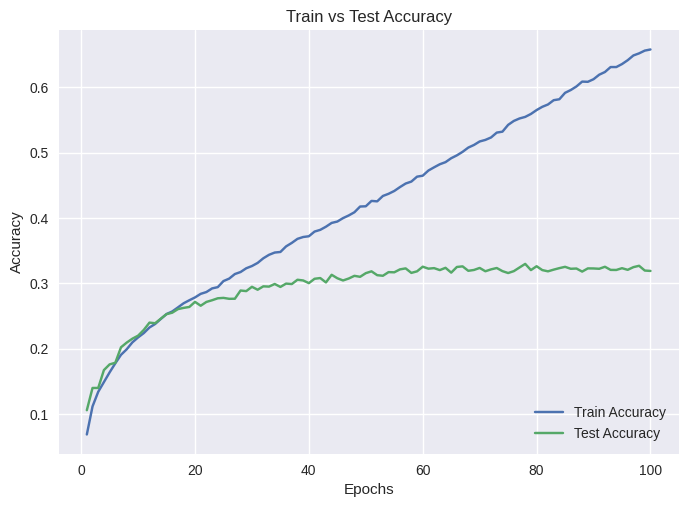

In [13]:
plt.style.use("seaborn")
train_accs_data = [acc.cpu().item() for acc in train_accs]
test_accs_data = [acc.cpu().item() for acc in test_accs]
plt.plot(range(1, 101), train_accs_data, label="Train Accuracy")
plt.plot(range(1, 101), test_accs_data, label="Test Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc="lower right")

In [14]:
pred_labels ,true_labels = test(model, test_dataloader)
true_labels = [label.cpu().item() for label in true_labels]
pred_labels = [label.cpu().item() for label in pred_labels]

100%|██████████| 313/313 [00:03<00:00, 91.46it/s] 


####  Superclass confusion matrix

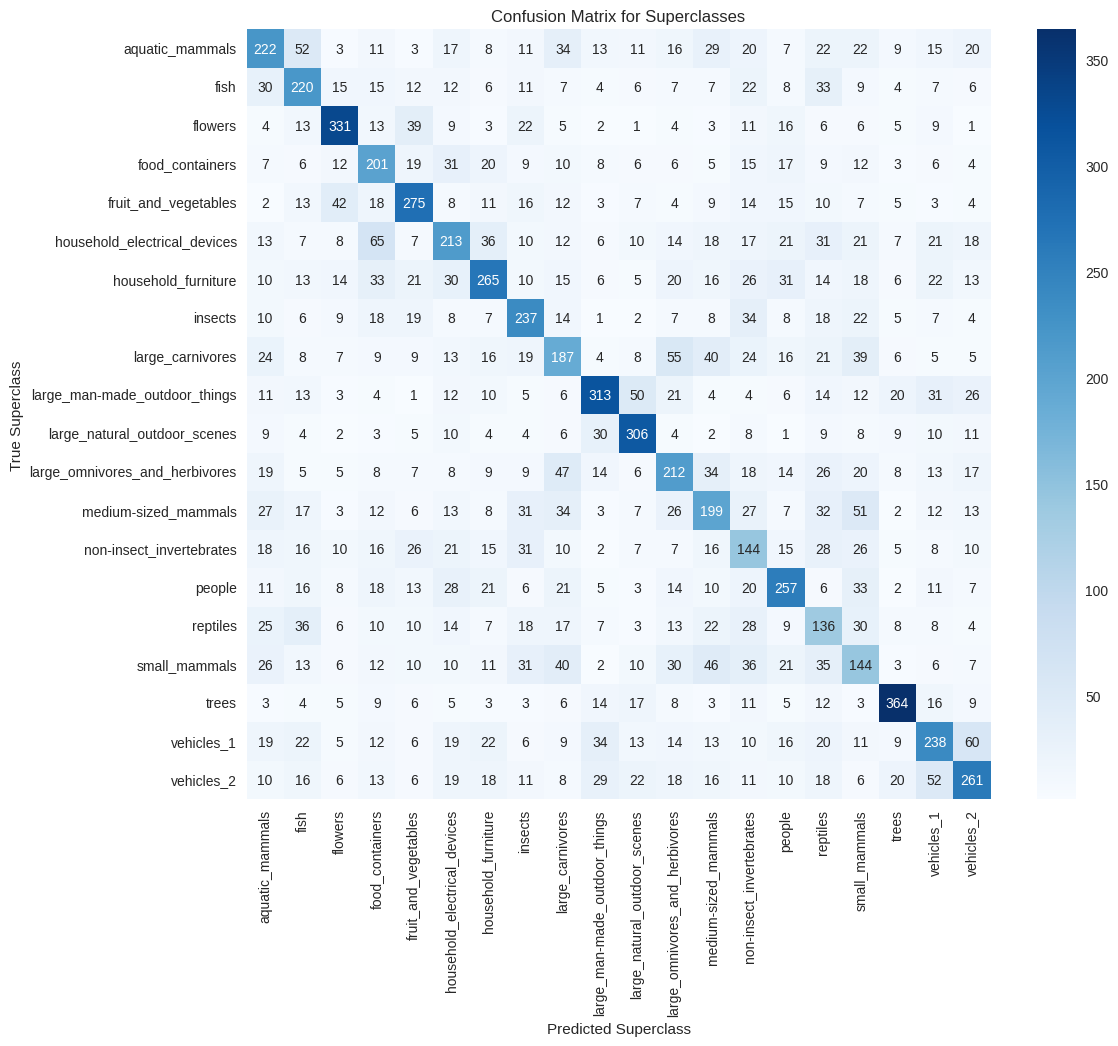

In [15]:
# Confusion matrix for superclass

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)


cm_superclass = confusion_matrix(pred_superclass_labels, true_superclass_labels)

# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_superclass, annot=True, xticklabels=superclass_to_classes.keys(), yticklabels=superclass_to_classes.keys(), cmap="Blues", fmt="d")
plt.xlabel("Predicted Superclass")
plt.ylabel("True Superclass")
plt.title("Confusion Matrix for CIFAR-100 Classification")
plt.title("Confusion Matrix for Superclasses")
plt.show()

####  Childclass confusion matrix

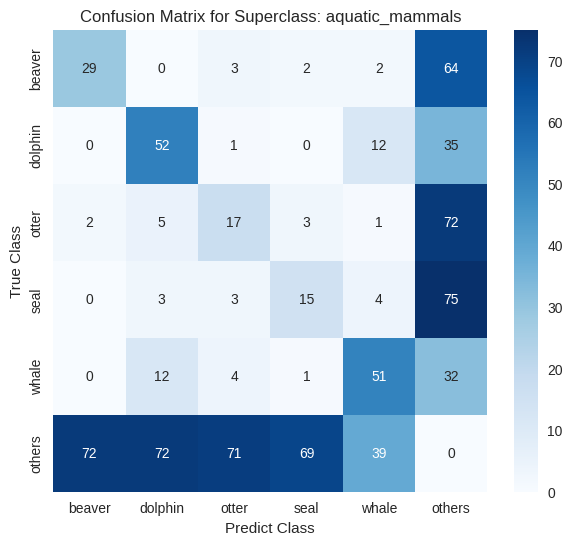

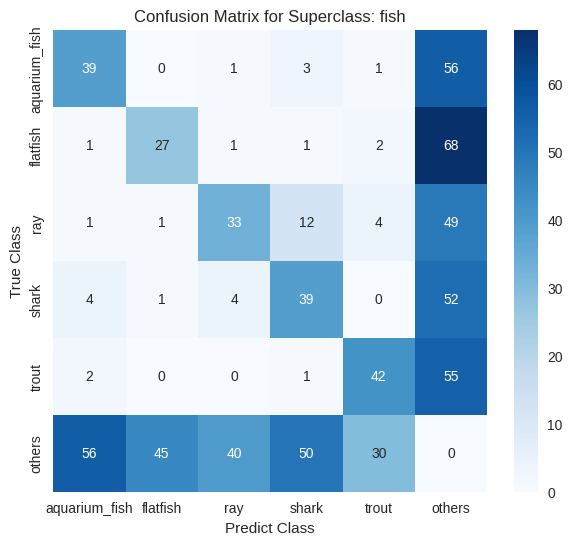

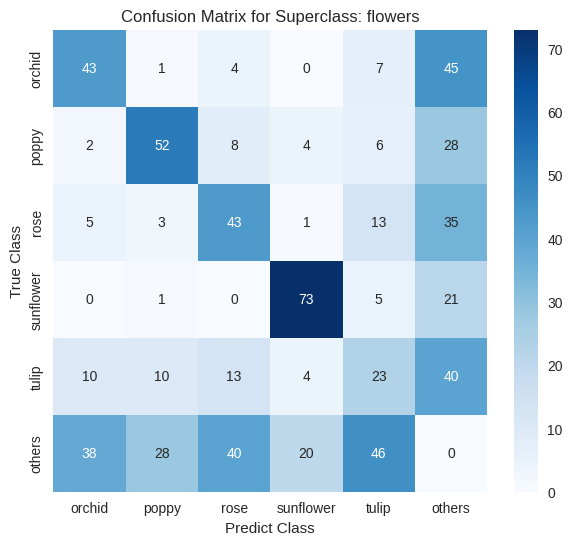

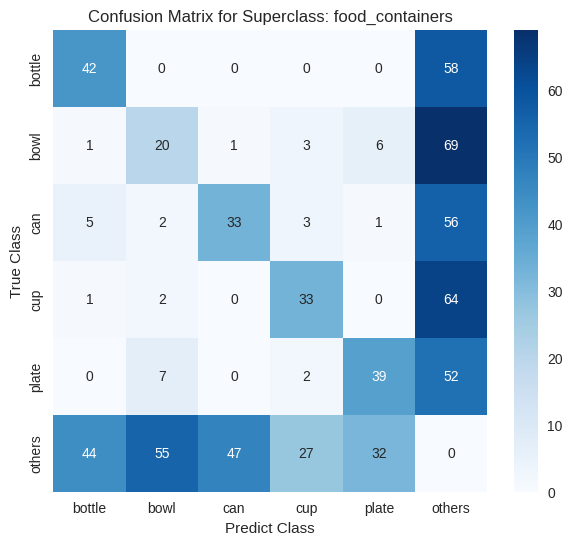

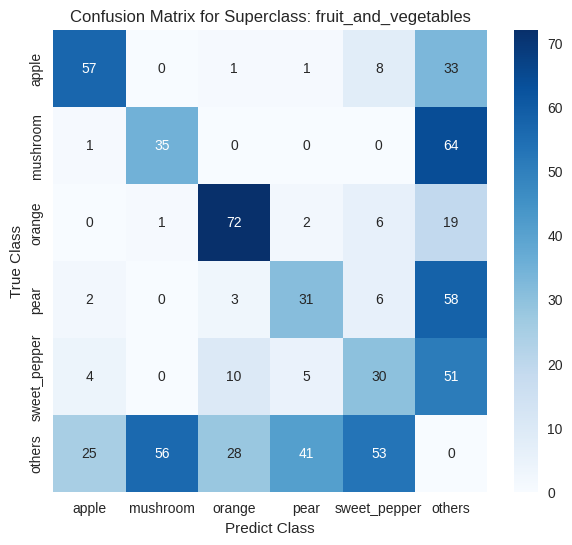

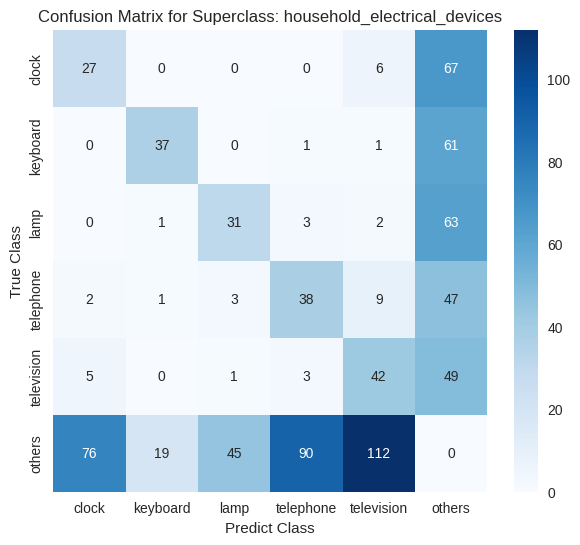

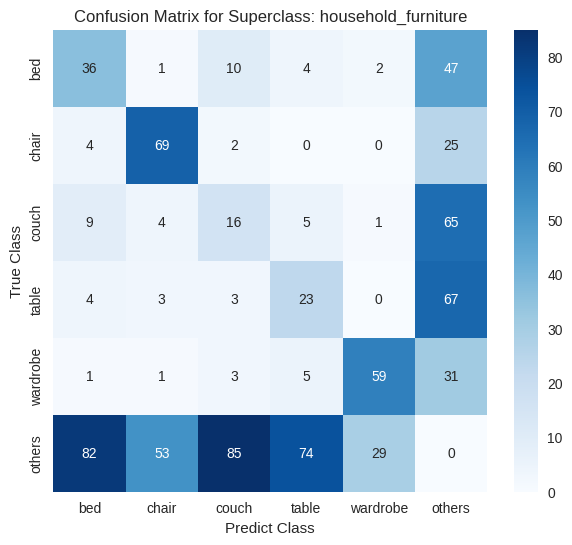

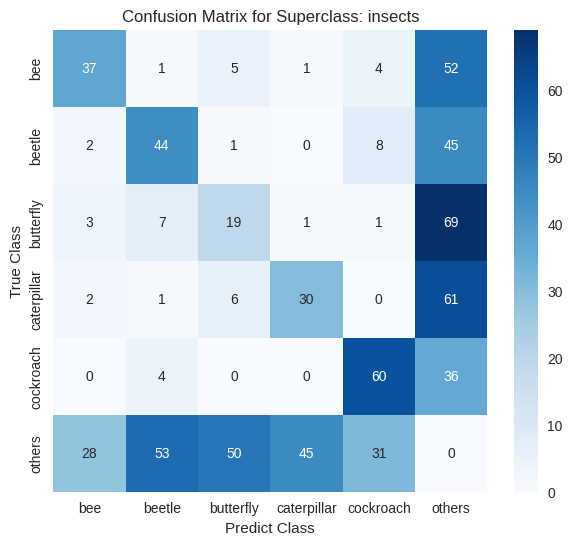

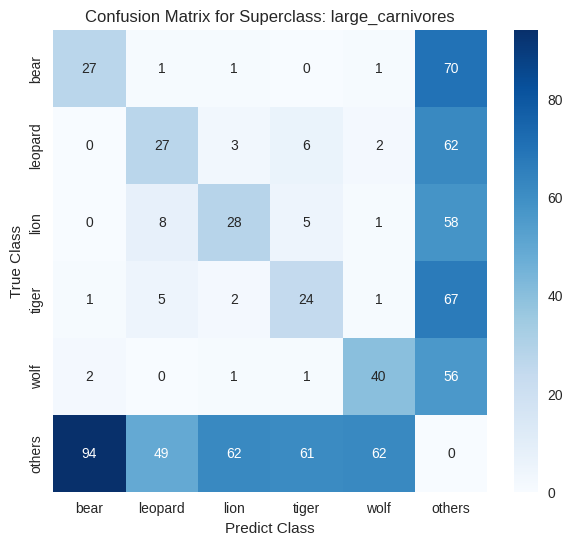

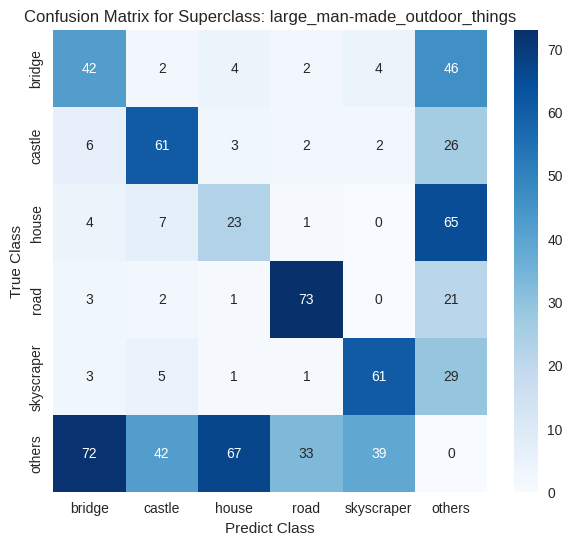

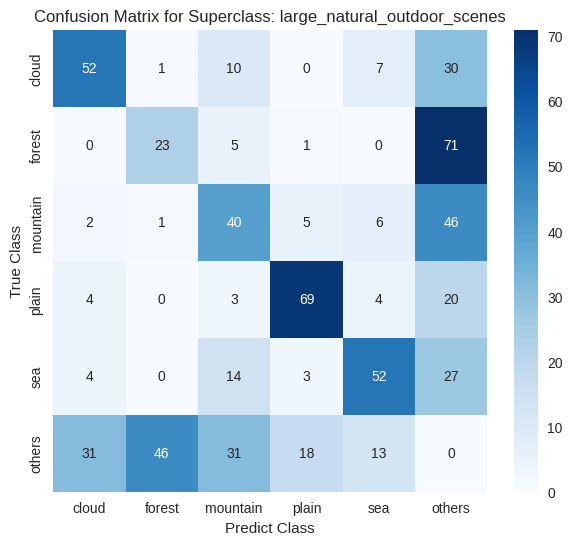

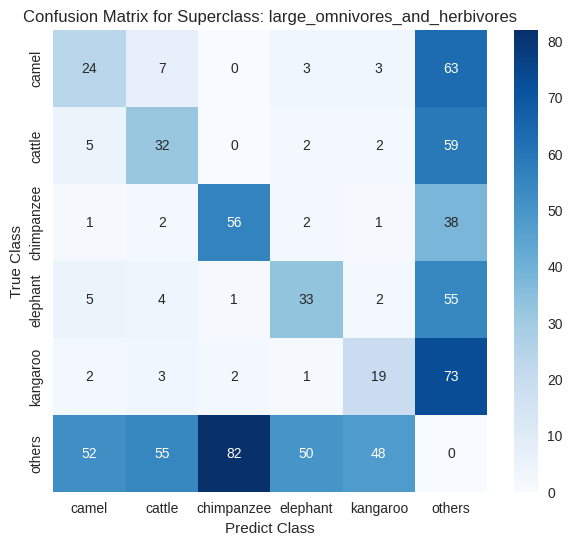

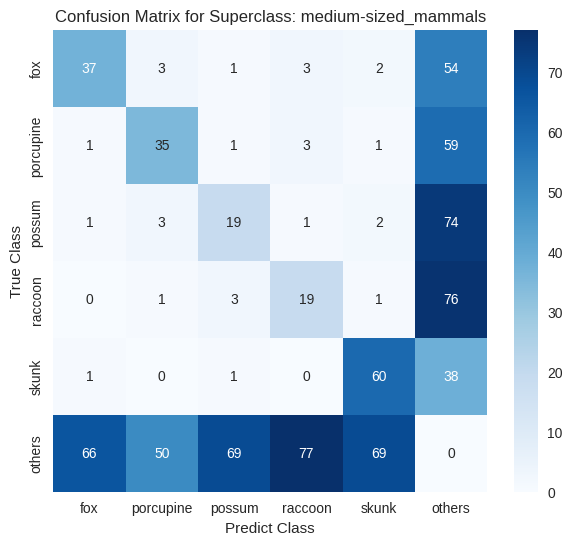

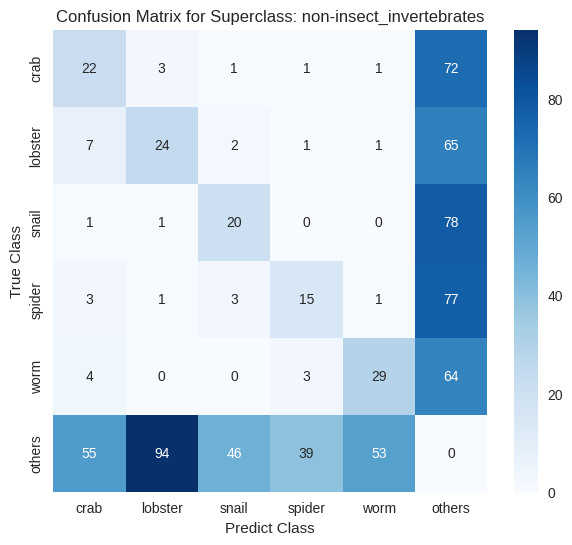

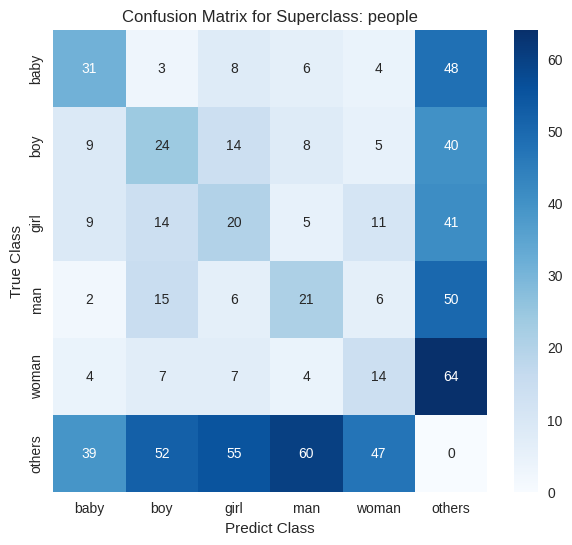

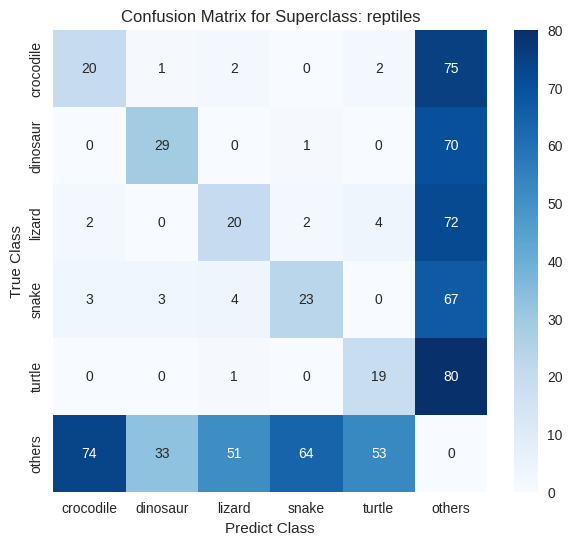

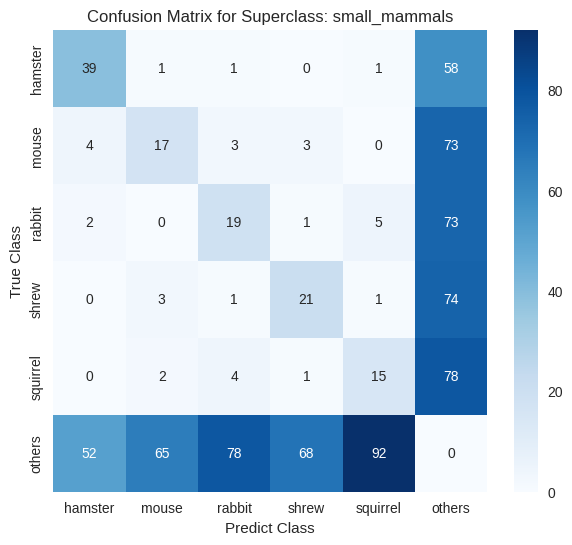

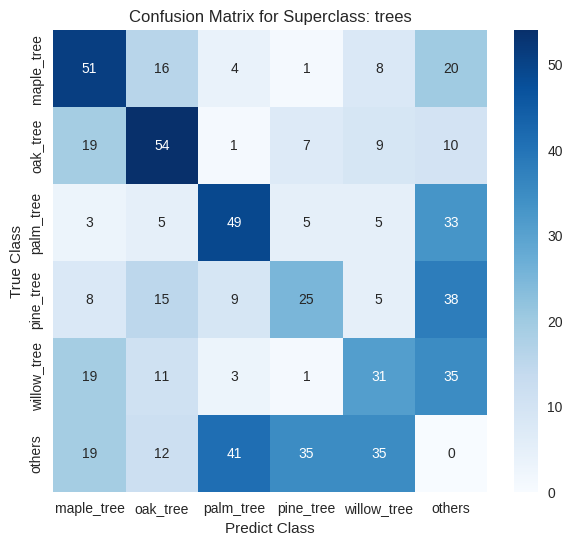

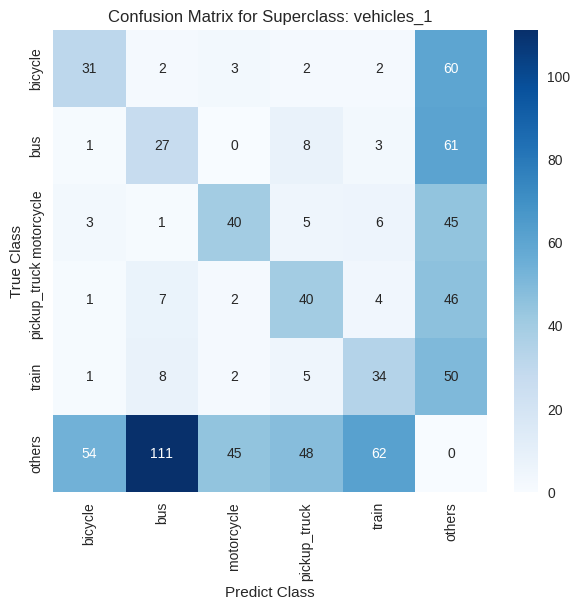

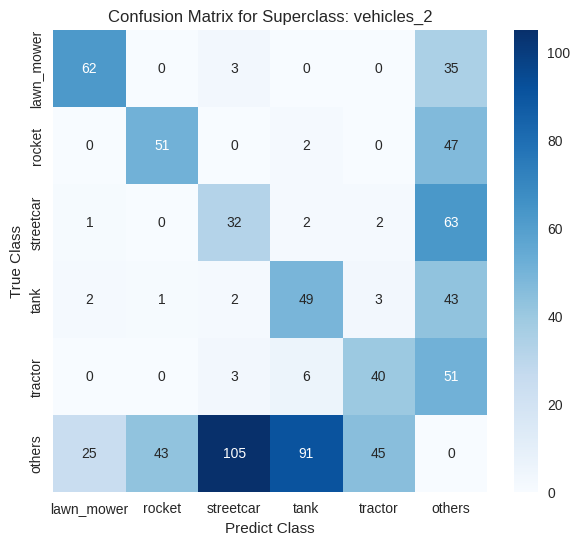

In [16]:
# Confusion matrix for superclass
true_class_labels = list_class_label(true_labels)
pred_class_labels = list_class_label(pred_labels)

superclass = {
    'aquatic_mammals': { 'true_label': [], 'pred_label': [] },
    'fish': { 'true_label': [], 'pred_label': [] },
    'flowers': { 'true_label': [], 'pred_label': [] },
    'food_containers': { 'true_label': [], 'pred_label': [] },
    'fruit_and_vegetables': { 'true_label': [], 'pred_label': [] },
    'household_electrical_devices': { 'true_label': [], 'pred_label': [] },
    'household_furniture': { 'true_label': [], 'pred_label': [] },
    'insects': { 'true_label': [], 'pred_label': [] },
    'large_carnivores': { 'true_label': [], 'pred_label': [] },
    'large_man-made_outdoor_things': { 'true_label': [], 'pred_label': [] },
    'large_natural_outdoor_scenes': { 'true_label': [], 'pred_label': [] },
    'large_omnivores_and_herbivores': { 'true_label': [], 'pred_label': [] },
    'medium-sized_mammals': { 'true_label': [], 'pred_label': [] },
    'non-insect_invertebrates': { 'true_label': [], 'pred_label': [] },
    'people': { 'true_label': [], 'pred_label': [] },
    'reptiles': { 'true_label': [], 'pred_label': [] },
    'small_mammals': { 'true_label': [], 'pred_label': [] },
    'trees': { 'true_label': [], 'pred_label': [] },
    'vehicles_1': { 'true_label': [], 'pred_label': [] },
    'vehicles_2': { 'true_label': [], 'pred_label': [] },
}

child_class = test_dataloader.dataset.classes

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)

for true_label, pred_label in zip(true_class_labels, pred_class_labels):
    true_label_superclass = get_super_by_child(true_label)
    pred_label_superclass = get_super_by_child(pred_label)
    if true_label_superclass == pred_label_superclass:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append(pred_label)
    else:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append('others')
        superclass[f'{pred_label_superclass}']['true_label'].append('others')
        superclass[f'{pred_label_superclass}']['pred_label'].append(pred_label)

colors = [
    "Blues", "BuGn", "BuPu", "GnBu", "OrRd", "PuBu", "PuRd", "RdPu", 
    "YlGn", "YlGnBu", "YlOrBr", "YlOrRd", "Oranges", "Purples", "Greens", 
    "Reds", "coolwarm", "cividis", "magma", "viridis"
]

for super_class, class_label in superclass.items():
    classes = superclass_to_classes[super_class] + ['others']
    cm_class = confusion_matrix(class_label['true_label'], class_label['pred_label'], labels=classes)
    # Vẽ confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_class, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues", fmt="d")
    plt.xlabel("Predict Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for Superclass: {super_class}")
    plt.show()

## **LOAD MODEL AGAIN** 

In [17]:
# # Load previous checkpoint and assign to initial variables
# checkpoint = torch.load("VisionTransformer_CIFAR100_checkpoint.pt")
# last_epoch = checkpoint["epoch"]
# model = checkpoint["model"].to(device)
# optimizer = checkpoint["optimizer"]
# scheduler = checkpoint["scheduler"]
# train_accs = checkpoint["train_acc"]
# test_accs = checkpoint["test_acc"]

In [18]:
from calflops import calculate_flops
input_shape = (batch_size, channels, image_sz, image_sz)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  36.47 M 
fwd MACs:                                                               5.7632 GMACs
fwd FLOPs:                                                              11.5428 GFLOPS
fwd+bwd MACs:                                                           17.2897 GMACs
fwd+bwd FLOPs:                                                          34.6284 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mod